# Advanced Hybrid RAG с Cross-Encoder Reranking

Продвинутый RAG пайплайн: Hybrid retrieval (Semantic + BM25) + Cross-encoder reranking

**Архитектура:**
- 🏠 Локальные embeddings (HuggingFace E5)
- 🔍 Part 1: Hybrid RAG (Semantic + BM25)
- 🎯 Part 2: + Cross-encoder reranking
- 📊 Сравнение метрик в LangSmith

---

## 🔧 Используемые модели (multilingual с поддержкой русского)

| Компонент | Модель | Параметры | Размер | Retrieval Score | Rank |
|-----------|--------|-----------|--------|----------------|------|
| **Embeddings** | `intfloat/multilingual-e5-base` | 278M | 1.1 GB | 67.14 / 100 | #32 из 180 |
| **Cross-Encoder** | `cross-encoder/mmarco-mMiniLMv2-L12-H384-v1` | 117.6M | 470 MB | multilingual | - |

**Почему эти модели?**
- Retrieval 67.14 - хорошее качество для размера
- Работают на CPU без GPU
- 100+ языков включая русский
- Оптимальный баланс качество/ресурсы
- Топ-1 модель (81.15) в 12x тяжелее при +14 пунктах качества

## 💻 Требования к ресурсам

**Минимальные (для запуска на CPU):**
- RAM: 4-6 GB свободной памяти
- CPU: 4 ядра

**Рекомендованные:**
- RAM: 8-16 GB
- CPU: 8+ ядер с AVX2

**GPU не требуется!** ✅ Все модели работают на CPU


## Установка зависимостей


In [1]:
%pip install -qU langchain langchain-classic langchain-openai langchain-community langchain-core langchain-text-splitters langchain-huggingface
%pip install -qU pypdf python-dotenv rank-bm25
%pip install -qU langsmith ragas datasets sentence-transformers pandas matplotlib



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Настройка окружения


In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY не установлен"
assert os.getenv("LANGSMITH_API_KEY"), "LANGSMITH_API_KEY не установлен"

# Отключаем warning от tokenizers (возникает при fork после parallelism)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("✓ Окружение настроено")


✓ Окружение настроено


In [3]:
from pathlib import Path
from typing import List, Dict, Any

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document

from sentence_transformers import CrossEncoder

from langsmith import Client
from ragas import evaluate
from ragas.metrics import (
    Faithfulness,
    ResponseRelevancy,
    AnswerCorrectness,
    AnswerSimilarity,
    ContextRecall,
    ContextPrecision,
)
from ragas.metrics.base import MetricWithLLM, MetricWithEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.run_config import RunConfig
from datasets import Dataset

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print("✓ Импорты выполнены")


✓ Импорты выполнены


## Загрузка документов


In [4]:
def load_pdf_documents(data_dir: str) -> List:
    pages = []
    for pdf_file in Path(data_dir).glob("*.pdf"):
        pages.extend(PyPDFLoader(str(pdf_file)).load())
    return pages

def split_documents(pages: List, chunk_size: int = 500, chunk_overlap: int = 50) -> List:
    return RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    ).split_documents(pages)

pages = load_pdf_documents("documents")
chunks = split_documents(pages)

print(f"✓ Загружено {len(pages)} страниц → {len(chunks)} чанков")


✓ Загружено 43 страниц → 423 чанков


## Part 1: Hybrid RAG (Semantic + BM25)

Создаем пайплайн с гибридным поиском без reranking


In [5]:
# 📚 Как выбрать embedding модель:
# 1. Открой https://huggingface.co/spaces/mteb/leaderboard
# 2. Отсортируйте рейтинг по колонке "Retrieval" (главная для RAG)
# 3. Фильтр Language-specific "Russian" для русского языка
#
# Топ моделей по MTEB(rus) Retrieval метрике (главная для RAG):
#
# Топ-5 по качеству Retrieval:
# 1. Giga-Embeddings-instruct (3B, 12.9GB) - Retrieval: 81.15 🥇 [слишком тяжелая]
# 2. FRIDA (823M, 3.1GB) - Retrieval: 77.17 🥈 [хорошо для сервера]
# 3. GritLM-7B (7B, 13.8GB) - Retrieval: 75.79 🥉 [очень тяжелая]
# 4. bge-m3 (568M, 2.2GB) - Retrieval: 74.79 [отлично для русского]
# 5. e5-mistral-7b-instruct (7B, 13.6GB) - Retrieval: 74.19 [тяжелая]
#
# Семейство E5 (оптимальны для CPU):
# • multilingual-e5-large-instruct (560M, 1.1GB) - Retrieval: 68.23, Rank #7
# • multilingual-e5-base (278M, 1.1GB) - Retrieval: 67.14, Rank #32 ⭐ НАШ ВЫБОР
# • multilingual-e5-small (118M, 449MB) - Retrieval: 65.85, Rank #37
#
# 💡 Почему multilingual-e5-base оптимален:
# ✅ Retrieval 67.14 - хорошее качество для размера
# ✅ Только 1.1 GB памяти - работает на CPU
# ✅ 100+ языков включая русский
# ✅ Разница с топ-1: -14 пунктов, но в 12x легче (1.1GB vs 12.9GB)
#
# 🎯 Создаем embedding модель для понимания смысла текста
# Превращает текст в векторы: похожие по смыслу тексты → похожие векторы
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-base",  # Модель с HuggingFace
    model_kwargs={'device': 'cpu'},  # 'cuda' для GPU, 'mps' для Mac M1/M2
    encode_kwargs={'normalize_embeddings': True}  # Нормализация для косинусного сходства
    # Полезные параметры: batch_size=32 (для больших объемов), show_progress=True
)

# 🔍 Semantic retriever - поиск по смыслу через векторное сходство
# Находит документы близкие по значению, даже если слова разные
vector_store = InMemoryVectorStore.from_documents(chunks, embeddings)
semantic_retriever = vector_store.as_retriever(
    search_type="similarity",  # "similarity" (default), "mmr" (разнообразие), "similarity_score_threshold" (с порогом)
    search_kwargs={
        "k": 10  # Топ-10 результатов
        # "score_threshold": 0.5,  # Порог similarity score (0-1), работает только с search_type="similarity_score_threshold"
        # "fetch_k": 20,  # Для MMR: сначала берем 20, потом MMR выбирает 10 самых разных
        # "lambda_mult": 0.5,  # Для MMR: баланс релевантность/разнообразие (0=макс разнообразие, 1=макс релевантность)
    }
)

# 📊 BM25 retriever - классический поиск по точным совпадениям слов
# Хорошо находит конкретные термины, номера, названия
bm25_retriever = BM25Retriever.from_documents(chunks)
bm25_retriever.k = 10  # Количество результатов

# 🎯 Ensemble - объединяем оба подхода (гибридный поиск)
# Semantic ловит синонимы, BM25 ловит точные термины
# RRF (Reciprocal Rank Fusion) объединяет результаты с весами 50/50
ensemble_retriever = EnsembleRetriever(
    retrievers=[semantic_retriever, bm25_retriever],
    weights=[0.5, 0.5]  # Веса для каждого retriever (сумма = 1.0)
    # Можно настроить: [0.7, 0.3] если semantic важнее, [0.3, 0.7] если BM25 важнее
)

print("✓ Hybrid retrieval готов (Semantic + BM25)")


✓ Hybrid retrieval готов (Semantic + BM25)


In [6]:
# LLM и промпт
llm = ChatOpenAI(model="gpt-4.1", temperature=0.0)

SYSTEM_TEMPLATE = """Ты помощник для ответов на вопросы на основе контекста.
Используй только информацию из контекста.
Если ответа нет, скажи "Я не нашел ответа в документах".

Контекст:
{context}"""

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_TEMPLATE),
    ("human", "{question}"),
])

# LCEL chain для Hybrid RAG
hybrid_rag_chain = (
    RunnablePassthrough.assign(
        documents=lambda x: ensemble_retriever.invoke(x["question"])
    )
    | RunnablePassthrough.assign(
        answer=lambda x: (prompt | llm | StrOutputParser()).invoke({
            "context": "\n\n".join(doc.page_content for doc in x["documents"]),
            "question": x["question"]
        })
    )
    | (lambda x: {"answer": x["answer"], "documents": x["documents"]})
)

print("✓ Hybrid RAG chain готов")


✓ Hybrid RAG chain готов


In [7]:
# Тест
result = hybrid_rag_chain.invoke({"question": "Что нужно для открытия вклада?"})
print(f"Ответ: {result['answer'][:200]}...")
print(f"Использовано документов: {len(result['documents'])}")


Ответ: Для открытия вклада необходимо:

- Заключить Договор банковского вклада с Банком.
- Предъявить паспорт или иной документ, удостоверяющий личность.
- Если операция совершается в интересах других лиц (В...
Использовано документов: 19


## Evaluation Setup

Подготовка датасета и функций для evaluation


In [8]:
# Загрузка существующего датасета
DATASET_NAME = "SBERAGENTS_RAG_EVALUATION_DATASET_V1"

client = Client()
datasets = list(client.list_datasets(dataset_name=DATASET_NAME))

if datasets:
    print(f"✓ Найден датасет: {DATASET_NAME}")
else:
    print(f"⚠️ Датасет {DATASET_NAME} не найден. Создайте его сначала.")


✓ Найден датасет: SBERAGENTS_RAG_EVALUATION_DATASET_V1


In [9]:
# Инициализация RAGAS метрик
def init_ragas_metrics(metrics, llm, embedding):
    for metric in metrics:
        if isinstance(metric, MetricWithLLM):
            metric.llm = llm
        if isinstance(metric, MetricWithEmbeddings):
            metric.embeddings = embedding
        metric.init(RunConfig())

langchain_llm = ChatOpenAI(model="gpt-4.1", temperature=0)

# Используем HuggingFace embeddings для RAGAS (по аналогии с основными embeddings)
langchain_embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-base",
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

ragas_metrics = [
    Faithfulness(),
    ResponseRelevancy(strictness=1),
    AnswerCorrectness(),
    AnswerSimilarity(),
    ContextRecall(),
    ContextPrecision(),
]

init_ragas_metrics(
    ragas_metrics,
    llm=LangchainLLMWrapper(langchain_llm),
    embedding=LangchainEmbeddingsWrapper(langchain_embeddings),
)

ragas_run_config = RunConfig(max_workers=4, max_wait=180, max_retries=3)

print(f"✓ RAGAS метрики готовы: {', '.join([m.name for m in ragas_metrics])}")


✓ RAGAS метрики готовы: faithfulness, answer_relevancy, answer_correctness, answer_similarity, context_recall, context_precision


/var/folders/_k/7q0q098s44bc8pbczmplf_8h0000gn/T/ipykernel_20514/4228638086.py:24: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  llm=LangchainLLMWrapper(langchain_llm),
/var/folders/_k/7q0q098s44bc8pbczmplf_8h0000gn/T/ipykernel_20514/4228638086.py:25: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  embedding=LangchainEmbeddingsWrapper(langchain_embeddings),


In [10]:
# Функция evaluation с RAGAS feedback в LangSmith
def evaluate_pipeline_with_ragas_feedback(pipeline_name: str, target: callable, dataset_name: str, metadata: dict = None):
    if metadata is None:
        metadata = {}
    
    print(f"\n{'='*70}")
    print(f"Evaluation: {pipeline_name}")
    print(f"{'='*70}")
    
    questions, answers, contexts_list, ground_truths, run_ids = [], [], [], [], []
    
    print(f"[1/3] Запуск эксперимента...")
    
    for result in client.evaluate(
        target,
        data=dataset_name,
        evaluators=[],
        experiment_prefix=f"rag-{pipeline_name}",
        metadata={"pipeline": pipeline_name, **metadata},
        blocking=False,
    ):
        run = result["run"]
        example = result["example"]
        
        questions.append(run.inputs.get("question", ""))
        answers.append(run.outputs.get("answer", ""))
        documents = run.outputs.get("documents", [])
        contexts_list.append([doc.page_content if hasattr(doc, 'page_content') else str(doc) for doc in documents])
        ground_truths.append(example.outputs.get("answer", "") if example else "")
        run_ids.append(str(run.id))
    
    print(f"✓ Собрано {len(questions)} примеров")
    
    print(f"[2/3] RAGAS evaluation...")
    
    ragas_dataset = Dataset.from_dict({
        "question": questions,
        "answer": answers,
        "contexts": contexts_list,
        "ground_truth": ground_truths
    })
    
    ragas_result = evaluate(ragas_dataset, metrics=ragas_metrics, run_config=ragas_run_config)
    ragas_df = ragas_result.to_pandas()
    
    print(f"✓ Метрики:")
    for metric in ragas_metrics:
        if metric.name in ragas_df.columns:
            print(f"  {metric.name}: {ragas_df[metric.name].mean():.3f}")
    
    print(f"[3/3] Загрузка feedback в LangSmith...")
    
    for idx, run_id in enumerate(run_ids):
        row = ragas_df.iloc[idx]
        for metric in ragas_metrics:
            if metric.name in row:
                client.create_feedback(
                    run_id=run_id,
                    key=f"{metric.name}",
                    score=float(row[metric.name]),
                    comment=f"RAGAS metric: {metric.name}"
                )
    
    print(f"✓ Feedback загружен")
    print(f"{'='*70}\n")
    
    return {"pipeline_name": pipeline_name, "ragas_result": ragas_result, "run_ids": run_ids}

print("✓ Функция evaluation готова")


✓ Функция evaluation готова


## Evaluation Part 1: Hybrid RAG

Запускаем evaluation для Hybrid RAG (без reranking)


In [11]:
# Evaluation для Hybrid RAG
hybrid_result = evaluate_pipeline_with_ragas_feedback(
    pipeline_name="hybrid_rag",
    target=lambda inputs: hybrid_rag_chain.invoke(inputs),
    dataset_name=DATASET_NAME,
    metadata={
        "embeddings": "multilingual-e5-base (local)",
        "retrieval": "Semantic + BM25 (RRF)",
        "reranking": "none",
        "llm": "gpt-4.1"
    }
)



Evaluation: hybrid_rag
[1/3] Запуск эксперимента...
View the evaluation results for experiment: 'rag-hybrid_rag-1ba3c490' at:
https://smith.langchain.com/o/e89c996e-33ee-468d-9390-ff88ce6a317b/datasets/08dee2b9-21e6-45f1-bebb-b31dc2d92442/compare?selectedSessions=e225f0e6-c035-4e85-81e8-429ba5a3687c




0it [00:00, ?it/s]

✓ Собрано 4 примеров
[2/3] RAGAS evaluation...


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

✓ Метрики:
  faithfulness: 0.750
  answer_relevancy: 0.009
  answer_correctness: 0.444
  answer_similarity: 0.702
  context_recall: 1.000
  context_precision: 0.687
[3/3] Загрузка feedback в LangSmith...
✓ Feedback загружен



## Part 2: Cross-Encoder Reranking

Добавляем reranking поверх Hybrid RAG


In [12]:
# 📚 Как выбрать cross-encoder модель:
# 1. Открой https://huggingface.co/cross-encoder/models?sort=downloads или https://huggingface.co/models?other=cross-encoder&sort=downloads
# 2. Проверь model card → языки → метрики (если есть)
# 3. Приоритеты: multilingual > downloads > размер
#
# Топ-3 для multilingual:
# 1. BAAI/bge-reranker-v2-m3 (568M, 2.2GB) - топ качество [тяжелый]
# 2. cross-encoder/mmarco-mMiniLMv2-L12-H384-v1 (117M, 470MB) ⭐ НАШ ВЫБОР
#    Выбрали: 14 языков (включая ru), компактный, обучен на mMARCO
# 3. cross-encoder/ms-marco-MiniLM-L6-v2 (22M, 87MB) - только английский [быстрый]
#
# Используемая модель: cross-encoder/mmarco-mMiniLMv2-L12-H384-v1
# - Параметры: 117.6M
# - Размер: ~470 MB
# - Архитектура: XLM-RoBERTa
# - Языки: en, ar, zh, nl, fr, de, hi, it, ja, pt, ru, es, vi
# - Обучен на: mMARCO (multilingual MS MARCO)
cross_encoder = CrossEncoder('cross-encoder/mmarco-mMiniLMv2-L12-H384-v1')

def rerank_documents(query: str, documents: List[Document], top_k: int = 3):
    """Reranking документов с cross-encoder"""
    # Создаем пары (запрос, документ) для cross-encoder
    pairs = [(query, doc.page_content) for doc in documents]
    
    # Cross-encoder оценивает релевантность каждой пары
    scores = cross_encoder.predict(pairs)
    
    # Сортируем документы по убыванию score
    ranked = sorted(zip(documents, scores), key=lambda x: x[1], reverse=True)
    
    # Возвращаем top_k наиболее релевантных документов
    return ranked[:top_k]

# LCEL chain с reranking
hybrid_reranked_chain = (
    RunnablePassthrough.assign(
        ensemble_docs=lambda x: ensemble_retriever.invoke(x["question"])
    )
    | RunnablePassthrough.assign(
        documents=lambda x: [doc for doc, score in rerank_documents(
            x["question"], 
            x["ensemble_docs"], 
            top_k=3
        )]
    )
    | RunnablePassthrough.assign(
        answer=lambda x: (prompt | llm | StrOutputParser()).invoke({
            "context": "\n\n".join(doc.page_content for doc in x["documents"]),
            "question": x["question"]
        })
    )
    | (lambda x: {"answer": x["answer"], "documents": x["documents"]})
)

print("✓ Hybrid RAG + Cross-encoder reranking готов")


✓ Hybrid RAG + Cross-encoder reranking готов


In [13]:
# Тест
result = hybrid_reranked_chain.invoke({"question": "Что нужно для открытия вклада?"})
print(f"Ответ: {result['answer']}")
print(f"Использовано документов: {len(result['documents'])}")


Ответ: Для открытия вклада необходимо:

1. Оформить распоряжение на открытие вклада, в котором указываются вид вклада, сумма вклада, валюта вклада, срок вклада, процентная ставка по вкладу, Ф.И.О.
2. Оформить распоряжение через «Сбербанк Онлайн» с применением средств идентификации и аутентификации, определённых Договором банковского обслуживания/Договором о предоставлении доступа физических лиц к продуктам ПАО Сбербанк.
3. Распоряжение подписывается в электронном виде с использованием аналога собственноручной подписи/простой электронной подписи в соответствии с Договором.

Я не нашел в документах других требований для открытия вклада.
Использовано документов: 3


## Evaluation Part 2: + Reranking

Запускаем evaluation с reranking'ом


In [14]:
# Evaluation для Hybrid RAG + Reranking
reranked_result = evaluate_pipeline_with_ragas_feedback(
    pipeline_name="hybrid_rag_reranked",
    target=lambda inputs: hybrid_reranked_chain.invoke(inputs),
    dataset_name=DATASET_NAME,
    metadata={
        "embeddings": "multilingual-e5-base (local)",
        "retrieval": "Semantic + BM25 (RRF)",
        "reranking": "cross-encoder/mmarco-mMiniLMv2-L12-H384-v1 (multilingual)",
        "llm": "gpt-4.1"
    }
)



Evaluation: hybrid_rag_reranked
[1/3] Запуск эксперимента...
View the evaluation results for experiment: 'rag-hybrid_rag_reranked-13770ae2' at:
https://smith.langchain.com/o/e89c996e-33ee-468d-9390-ff88ce6a317b/datasets/08dee2b9-21e6-45f1-bebb-b31dc2d92442/compare?selectedSessions=b9458805-dd1c-4939-9889-36309225c259




0it [00:00, ?it/s]

✓ Собрано 4 примеров
[2/3] RAGAS evaluation...


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

✓ Метрики:
  faithfulness: 0.725
  answer_relevancy: 0.011
  answer_correctness: 0.553
  answer_similarity: 0.713
  context_recall: 1.000
  context_precision: 1.000
[3/3] Загрузка feedback в LangSmith...
✓ Feedback загружен



## Сравнение результатов

Сравниваем метрики двух пайплайнов


Сравнение пайплайнов:
          Pipeline  faithfulness  answer_relevancy  answer_correctness  answer_similarity  context_recall  context_precision
        Hybrid RAG         0.750          0.008534            0.444181           0.702338             1.0           0.687482
Hybrid + Reranking         0.725          0.011320            0.553273           0.712949             1.0           1.000000


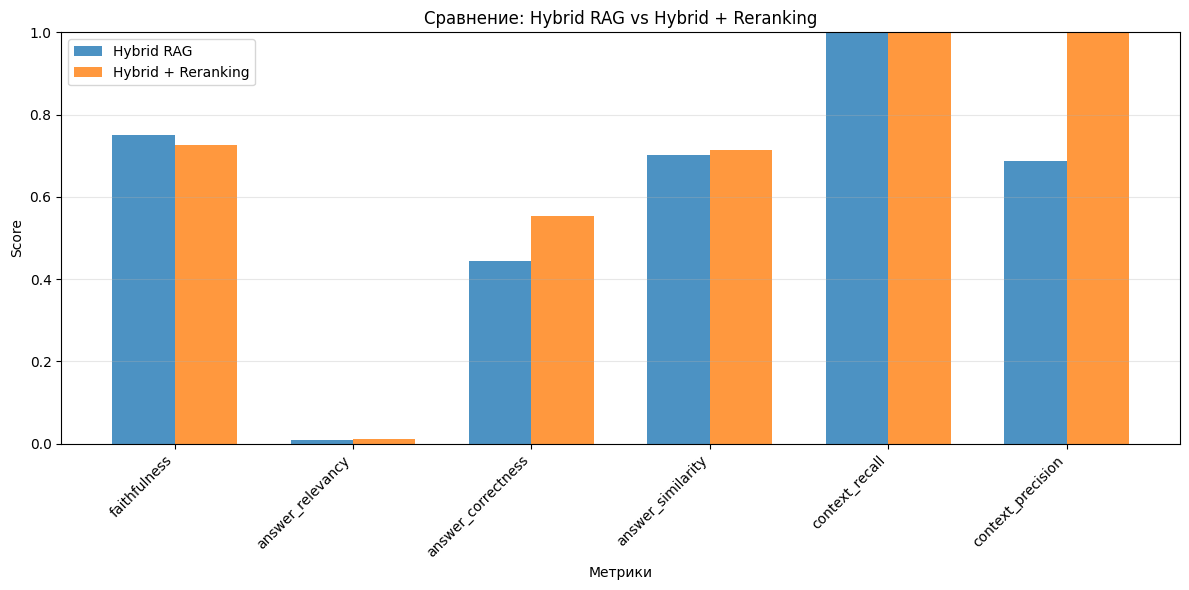


✅ Evaluation завершен. Проверьте результаты в LangSmith UI


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/gazebo/work/smirnoff_ai/courses/sberagents/sber-agents-live-rag/notebooks/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/asyncio/futures.py", line 202, in result
    raise self._exception.with_traceback(self._exception_tb)
  File "/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/asyncio/tasks.py", line 314, in __step_run_and_handle_result
    result = coro.send(None)
             ^^^^^^^^^^^^^^^
  File "/Users/gazebo/work/smirnoff_ai/courses/sberagents/sber-agents-live-rag/notebooks/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 341, in dispatch_control
    await self.process_control(msg)
  File "/Users/gazebo/work/smirnoff_ai/courses/sberagents/sber-agents-live-rag/notebooks/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", l

In [16]:
# Сравнение метрик
results_dict = {
    "Hybrid RAG": hybrid_result["ragas_result"].to_pandas(),
    "Hybrid + Reranking": reranked_result["ragas_result"].to_pandas()
}

comparison_data = []
for name, df in results_dict.items():
    row = {"Pipeline": name}
    for metric in ragas_metrics:
        if metric.name in df.columns:
            row[metric.name] = df[metric.name].mean()
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)

print("Сравнение пайплайнов:")
print(df_comparison.to_string(index=False))

# Визуализация
metric_names = [m.name for m in ragas_metrics if m.name in df_comparison.columns]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metric_names))
width = 0.35

hybrid_scores = [df_comparison[df_comparison['Pipeline'] == 'Hybrid RAG'][m].values[0] 
                 for m in metric_names]
reranked_scores = [df_comparison[df_comparison['Pipeline'] == 'Hybrid + Reranking'][m].values[0] 
                   for m in metric_names]

ax.bar(x - width/2, hybrid_scores, width, label='Hybrid RAG', alpha=0.8)
ax.bar(x + width/2, reranked_scores, width, label='Hybrid + Reranking', alpha=0.8)

ax.set_xlabel('Метрики')
ax.set_ylabel('Score')
ax.set_title('Сравнение: Hybrid RAG vs Hybrid + Reranking')
ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

print("\n✅ Evaluation завершен. Проверьте результаты в LangSmith UI")


## Итоги

**Part 1: Hybrid RAG (Semantic + BM25)**
- Локальные embeddings (multilingual-e5-base)
- Ensemble retriever с RRF fusion
- Результаты в LangSmith

**Part 2: + Cross-Encoder Reranking**
- Cross-encoder reranking поверх Hybrid retrieval
- Улучшение качества за счет переоценки релевантности
- Сравнение метрик

**Ключевые выводы:**
- Hybrid retrieval объединяет semantic и keyword search
- Cross-encoder улучшает качество финального ранжирования
- Все компоненты работают на CPU (кроме LLM)
- LCEL упрощает построение пайплайнов

